In [1]:
import os
import pandas as pd
import numpy as np
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import python_speech_features as psf
import matplotlib.pyplot as plt

In [2]:
voice_commands_dir = r'C:\Users\hp\Desktop\Handless Chess\voice_commands'
metadata_path = r'C:\Users\hp\Desktop\Handless Chess\metadata.csv'

In [3]:
metadata = pd.read_csv(metadata_path)

In [4]:
X = []
y = []

In [5]:
max_len = 100

for index, row in metadata.iterrows():
    file_path = os.path.join(voice_commands_dir, row['filename'])
    try:
        # Check if the file exists and is a valid file
        if not os.path.isfile(file_path):
            print(f"File not found: {file_path}")
            continue

        # Load audio file
        sample_rate, audio = wavfile.read(file_path)

        # Ensure audio data is not empty
        if len(audio) == 0:
            print(f"Empty audio data: {file_path}")
            continue

        # Extract MFCC features with a larger NFFT size
        mfccs = psf.mfcc(audio, samplerate=sample_rate, numcep=40, nfft=2048)

        # Pad MFCC features to a fixed length
        if mfccs.shape[0] < max_len:
            mfccs = np.pad(mfccs, ((0, max_len - mfccs.shape[0]), (0, 0)), mode='constant')
        else:
            mfccs = mfccs[:max_len]

        # Flatten the MFCCs to a single vector
        mfccs_processed = mfccs.flatten()

        # Append features and labels
        X.append(mfccs_processed)
        y.append(row['command'])
    except Exception as e:
        print(f"Error encountered while parsing file: {file_path}\n{str(e)}")
        continue

In [6]:
X = np.array(X)
y = np.array(y)

In [7]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# Reshape data for LSTM layer
X_train = np.reshape(X_train, (X_train.shape[0], max_len, -1))
X_test = np.reshape(X_test, (X_test.shape[0], max_len, -1))

In [8]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(le.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.2)

E:\ANACONDA\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.0565 - loss: 4.5052 - val_accuracy: 0.1000 - val_loss: 4.4529
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.2770 - loss: 4.2446 - val_accuracy: 0.1333 - val_loss: 4.3687
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.4556 - loss: 3.8983 - val_accuracy: 0.1667 - val_loss: 4.3122
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.4865 - loss: 3.5125 - val_accuracy: 0.2000 - val_loss: 4.2925
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.5913 - loss: 3.0373 - val_accuracy: 0.2000 - val_loss: 4.2816
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.7026 - loss: 2.2252 - val_accuracy: 0.2667 - val_loss: 4.3535
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.8198 - loss: 1.7857 - val_accuracy: 0.3333 - val_loss: 4.3404
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.7891 - loss: 1.4494 - val_accuracy: 0.4667 - 

In [9]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 4))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7545 - loss: 2.6786
Test Accuracy: 75.68%


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

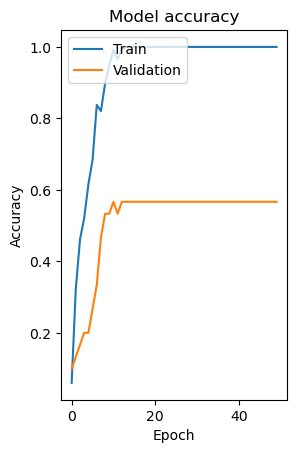

In [10]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

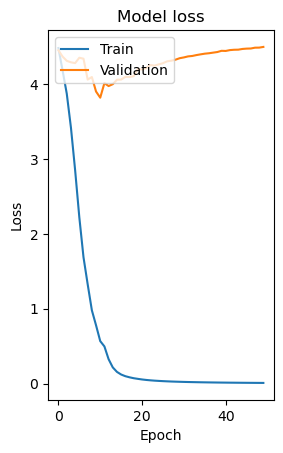

In [11]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


In [12]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Decode the classes to actual commands
y_pred_commands = le.inverse_transform(y_pred_classes)
y_test_commands = le.inverse_transform(y_test_classes)

# Display predicted and actual commands
for i in range(len(y_test_commands)):
    print(f"Predicted: {y_pred_commands[i]}, Actual: {y_test_commands[i]}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 472ms/step
Predicted: E7 to E8 Knight, Actual: King E1 to D1
Predicted: Pawn C2 to C3, Actual: Pawn C2 to C3
Predicted: Queen D8 to G5, Actual: Queen D8 to G5
Predicted: E7 to E8 Knight, Actual: King E1 to D1
Predicted: E7 to E8 Knight, Actual: Queen D1 to D3
Predicted: E7 to E8 Bishop, Actual: E7 to E8 Bishop
Predicted: Queen D8 to G5, Actual: King E8 to D8
Predicted: Rook A1 to A3, Actual: Rook A1 to A3
Predicted: King E8 to D8, Actual: King E8 to D8
Predicted: Bishop C8 to E3, Actual: Bishop C8 to E3
Predicted: Bishop C8 to E2, Actual: Bishop C8 to E2
Predicted: Rook A1 to E1, Actual: Rook A1 to E1
Predicted: Rook A1 to D1, Actual: Rook A1 to D1
Predicted: Pawn H2 to H4, Actual: Bishop F1 to A6
Predicted: Pawn D2 to D4, Actual: Pawn D2 to D4
Predicted: E7 to E8 Knight, Actual: E7 to E8 Knight
Predicted: Pawn G2 to G4, Actual: Pawn G2 to G4
Predicted: Knight G1 to H3, Actual: Knight G1 to H3
Predicted: Pawn H2 to H4, Actual: Bishop F1 to A6
Predicted: E7 t